# 1. Softmax & Cross entropy loss
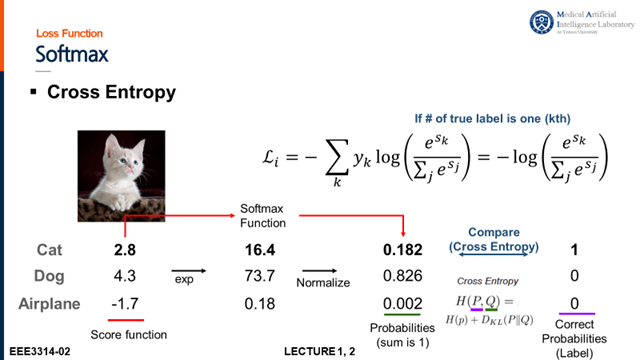


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get_softmax(x): # calculate softmax values
  return np.exp(x)/np.sum(np.exp(x), axis=0)

In [ ]:
def Loss_softmax(s, y):
  # Cross entropy loss calculation
  [num_class, num_sample] = s.shape
  Li = 0
  for i in range(num_sample):
    ysample = y[:,i]
    ssample = s[:,i]
    softmax_value = get_softmax(ssample)
    Li += np.sum(-np.log(softmax_value)*ysample)
  return (Li / num_sample)

In [ ]:
def Loss_reg(W, dim=2):
    if dim == 1: # L1 regularization:
        reg = np.sum(abs(W))
    elif dim == 2:
        reg = np.sum(W**2)

    return reg

In [ ]:
# the number of sample = 1

num_size = 4
num_class = 3

num_sample = 1

# y = Wx + b

x = np.random.randint(255, size = (num_size, num_sample)) # Input (size 4 x 1)
W = np.random.normal(0, 0.01, size = (num_class, num_size)) # Weights (size 3 x 4)
b = np.random.normal(0, 1, size = (num_class, num_sample)) # bias (size 3 x 1)

s = np.dot(W, x) + b # Score (size 3x1)
y = np.array([1, 0, 0])[..., np.newaxis] # label

print(x, '<-- x')
print(W, '<-- W')
print(b, '<-- b')
print(s, '<-- s')
print(y, '<-- y')

[[186]
 [254]
 [138]
 [ 31]] <-- x
[[-0.00748551  0.01049388 -0.00617642  0.00160913]
 [ 0.00114768  0.00231746 -0.00296235  0.00141481]
 [ 0.00388579 -0.00399455  0.00061458  0.01303791]] <-- W
[[-0.24212075]
 [ 0.69606181]
 [-1.09258825]] <-- b
[[ 0.22855807]
 [ 1.13322013]
 [-0.89545959]] <-- s
[[1]
 [0]
 [0]] <-- y


In [ ]:
print(np.round(get_softmax(s), 5), '<-- softmax value')
print('CE(softmax) loss :', np.round(Loss_softmax(s, y),5))

[[0.26343]
 [0.65096]
 [0.08561]] <-- softmax value
CE(softmax) loss : 1.33397


### 1.2 MNIST case

In [ ]:
import sklearn.datasets
mnist = sklearn.datasets.fetch_openml('mnist_784', data_home="mnist_784")

In [ ]:
num_sample = 5000
num_class = 10

x_data = mnist.data[:num_sample].T
x_data = x_data/np.max(x_data)
img_size = x_data[:,0].size
y_index = mnist.target[:num_sample]

y = np.zeros((num_class, num_sample))
for idx in range(num_sample):
    y[int(y_index[idx]), idx] = 1    

x = np.reshape(x_data, (-1, num_sample)) # Input (size 782 x 5000) --> (image_size x sample)
W = np.random.normal(0, 0.001, size = (num_class, img_size)) # Weights (size 10 x 782) --> (class x image_size)
b = np.random.normal(0, 0.1, size = (num_class, num_sample)) # bias (size 10 x 5000) --> (class x sample)

s = np.dot(W, x) + b # Score (size 10 x 1)

In [ ]:
softmax = np.round(get_softmax(s),5)
loss_term = np.round(Loss_softmax(s, y),5)
reg_term_r2 = np.round(Loss_reg(W, dim=2),5)
print('loss_term :', loss_term) 
print('r2_regularization :', reg_term_r2) 
print('total loss :', loss_term + 0.01*reg_term_r2)

loss_term : 2.30283
r2_regularization : 0.00768
total loss : 2.3029068


# 2. MLP and backpropagation implementation with **Numpy** library using MNIST dataset



In [ ]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [ ]:
import numpy as np
import sklearn.datasets

mnist = sklearn.datasets.fetch_openml('mnist_784', data_home="mnist_784")

In [ ]:
# data preprocessing

num_train = 60000
num_class = 10

x_train = np.float32(mnist.data[:num_train]).T
y_train_index = np.int32(mnist.target[:num_train]).T
x_test = np.float32(mnist.data[num_train:]).T
y_test_index = np.int32(mnist.target[num_train:]).T

# Normalization

x_train /= 255
x_test /= 255
x_size = x_train.shape[0]

y_train = np.zeros((num_class, y_train_index.shape[0]))
for idx in range(y_train_index.shape[0]):
  y_train[y_train_index[idx], idx] = 1

y_test = np.zeros((num_class, y_test_index.shape[0]))
for idx in range(y_test_index.shape[0]):
  y_test[y_test_index[idx], idx] = 1    

In [ ]:
#parameter initialization

hidden_size = 64 # hidden unit size

# two-layer neural network

params = {"W1": np.random.randn(hidden_size, x_size) * np.sqrt(1/ x_size),
          "b1": np.zeros((hidden_size, 1)) * np.sqrt(1/ x_size),
          "W2": np.random.randn(num_class, hidden_size) * np.sqrt(1/ hidden_size),
          "b2": np.zeros((num_class, 1)) * np.sqrt(1/ hidden_size)
          }
# Xavier initialization: https://reniew.github.io/13/

In [ ]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def d_sigmoid(x):
  # derivative of sigmoid
  exp = np.exp(-x)
  return (exp)/((1+exp)**2)

def softmax(x):
  exp = np.exp(x)
  return exp/np.sum(exp, axis=0)

In [ ]:
def compute_loss(y_true, y_pred):
  # loss calculation
  num_sample = y_true.shape[1]
  Li = -1 * np.sum(y_true * np.log(y_pred))
  
  return Li/num_sample

In [ ]:
def foward_pass(x, params):
  
  params["S1"] = np.dot(params["W1"], x) + params["b1"]
  params["A1"] = sigmoid(params["S1"])
  params["S2"] = np.dot(params["W2"], params["A1"]) + params["b2"]
  params["A2"] = softmax(params["S2"])

  return params

In [ ]:
def foward_pass_test(x, params):

  params_test = {}
  
  params_test["S1"] = np.dot(params["W1"], x) + params["b1"]
  params_test["A1"] = sigmoid(params_test["S1"])
  params_test["S2"] = np.dot(params["W2"], params_test["A1"]) + params["b2"]
  params_test["A2"] = softmax(params_test["S2"])

  return params_test

In [ ]:
def compute_accuracy(y_true, y_pred):
  y_true_idx = np.argmax(y_true, axis = 0)
  y_pred_idx = np.argmax(y_pred, axis = 0)
  num_correct = np.sum(y_true_idx==y_pred_idx)

  accuracy = num_correct / y_true.shape[1] * 100

  return accuracy

In [ ]:
def backward_pass(x, y_true, params):

  dS2 = params["A2"] - y_true
  # Please check http://machinelearningmechanic.com/deep_learning/2019/09/04/cross-entropy-loss-derivative.html
  # dS2 is softmax + CE loss derivative

  grads = {}

  grads["dW2"] =  np.dot(dS2, params["A1"].T)/x.shape[1]
  grads["db2"] =  (1/x.shape[1])*np.sum(dS2, axis=1, keepdims=True)/x.shape[1]

  dA1 = np.dot(params["W2"].T, dS2)
  dS1 = dA1 * d_sigmoid(params["S1"])

  grads["dW1"] = np.dot(dS1, x.T)/x.shape[1]
  grads["db1"] = np.sum(dS1, axis=1, keepdims=True)/x.shape[1]

  return grads

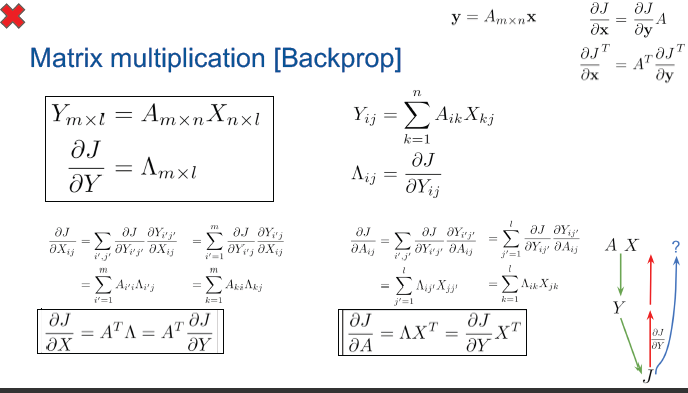

In [ ]:
epochs = 100
learning_rate = 0.5

for i in range(epochs):

  if i == 0:
    params = foward_pass(x_train, params)
    
  grads = backward_pass(x_train, y_train, params)

  params["W1"] -= learning_rate * grads["dW1"]
  params["b1"] -= learning_rate * grads["db1"]
  params["W2"] -= learning_rate * grads["dW2"]
  params["b2"] -= learning_rate * grads["db2"]

  params = foward_pass(x_train, params)
  train_loss = compute_loss(y_train, params["A2"])
  train_acc = compute_accuracy(y_train, params["A2"])

  params_test = foward_pass_test(x_test, params)
  test_loss = compute_loss(y_test, params_test["A2"])
  test_acc = compute_accuracy(y_test, params_test["A2"])

  print("Epoch {}: training loss = {}, training acuracy = {}%, test loss = {}, training acuracy = {}%"
  .format(i + 1, np.round(train_loss, 6), np.round(train_acc, 2), np.round(test_loss, 6), np.round(test_acc, 2)))

Epoch 1: training loss = 2.264686, training acuracy = 19.34%, test loss = 2.263175, training acuracy = 19.33%
Epoch 2: training loss = 2.231275, training acuracy = 37.86%, test loss = 2.229339, training acuracy = 38.95%
Epoch 3: training loss = 2.199055, training acuracy = 46.04%, test loss = 2.196434, training acuracy = 47.35%
Epoch 4: training loss = 2.167103, training acuracy = 51.39%, test loss = 2.163803, training acuracy = 53.16%
Epoch 5: training loss = 2.13522, training acuracy = 55.11%, test loss = 2.131258, training acuracy = 56.64%
Epoch 6: training loss = 2.103248, training acuracy = 58.05%, test loss = 2.098637, training acuracy = 59.62%
Epoch 7: training loss = 2.071055, training acuracy = 60.29%, test loss = 2.065806, training acuracy = 61.61%
Epoch 8: training loss = 2.038534, training acuracy = 62.08%, test loss = 2.032656, training acuracy = 63.55%
Epoch 9: training loss = 2.005605, training acuracy = 63.5%, test loss = 1.999107, training acuracy = 65.0%
Epoch 10: tra

# 3. MLP and backpropagation implementation with **Pytorch** library using MNIST dataset


In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [ ]:
num_train = 60000
num_class = 10

x_train = np.float32(mnist.data[:num_train])
y_train = np.int64(mnist.target[:num_train])
x_test = np.float32(mnist.data[num_train:])
y_test = np.int64(mnist.target[num_train:])

x_train /= 255
x_test /= 255
x_size = x_train.shape[1]

In [ ]:
x_train, y_train, x_test, y_test = map(
    torch.tensor, (x_train, y_train, x_test, y_test)
)

In [ ]:
class Classifier(nn.Module):
    def __init__(self, D_in, H, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
    
    def forward(self, x):
        x = F.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x     

In [ ]:
hidden_size = 64

model = Classifier(x_size, hidden_size, num_class)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.5)

In [ ]:
for i in range(epochs):

  outputs = model(x_train)
  loss = loss_func(outputs, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  train_loss = loss.item()
  print(train_loss)

  _, preds = torch.max(outputs, 1)
  num_corrects = torch.sum(preds == y_train)
  train_acc = num_corrects / len(y_train) * 100

  with torch.no_grad(): #test시에는 gradient를 계산하지 않음
    test_outputs = model(x_test)
    test_loss = loss_func(test_outputs, y_test).item()
    
    _, preds_test = torch.max(test_outputs, 1)
    num_corrects_test = torch.sum(preds_test == y_test)
    test_acc = num_corrects_test / len(y_test) * 100

  print("Epoch {}: training loss = {}, training acuracy = {}%, test loss = {}, training acuracy = {}%"
  .format(i + 1, np.round(train_loss, 6), np.round(train_acc.item(), 2), np.round(test_loss, 6), np.round(test_acc.item(), 2)))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2.3867430686950684
Epoch 1: training loss = 2.386743, training acuracy = 10.22%, test loss = 2.291704, training acuracy = 13.09%
2.293182373046875
Epoch 2: training loss = 2.293182, training acuracy = 13.1%, test loss = 2.276144, training acuracy = 12.72%
2.2772057056427
Epoch 3: training loss = 2.277206, training acuracy = 12.69%, test loss = 2.264101, training acuracy = 17.65%
2.2653050422668457
Epoch 4: training loss = 2.265305, training acuracy = 17.2%, test loss = 2.251867, training acuracy = 24.46%
2.2533187866210938
Epoch 5: training loss = 2.253319, training acuracy = 24.18%, test loss = 2.239275, training acuracy = 30.51%
2.2409932613372803
Epoch 6: training loss = 2.240993, training acuracy = 30.22%, test loss = 2.22622, training acuracy = 35.84%
2.2282161712646484
Epoch 7: training loss = 2.228216, training acuracy = 35.05%, test loss = 2.212598, training acuracy = 40.21%
2.2148828506469727
Epoch 8: training loss = 2.214883, training acuracy = 39.2%, test loss = 2.198308, tr